In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch

os.chdir('..')
from models.architectures.encoders.fc import HFCEncoder
from models.architectures.decoders.fc import HFCDecoder
from models.pt_vae import HFVAE
from multiprocessing import cpu_count
from trainer import VAETrainer
import json
import numpy as np
from utils.nn_utils import  set_seed

print(os.getcwd())

/home/dorian/FER/master_thesis/src/base


In [7]:
# model parameters

SEED = 50
set_seed(SEED)
INPUT_DIM = 2000
HIDDEN_DIM = 500
LATENT_DIM = 50
NUM_GROUPS = 10

# training parameters
BATCH_SIZE = 500
NUM_EPOCHS = 1000
LEARNING_RATE = 5e-5
CUDA = torch.cuda.is_available()
# beta template for hfvae (gammma, 1, alpha, beta, 0)
alpha = 0.0
beta = 10.0
gamma = 2.0
BETA = (gamma, 1.0, alpha, beta, 0.0)
parameters = {'SEED':SEED, 'INPUT_DIM':INPUT_DIM, 'HIDDEN_DIM':HIDDEN_DIM, 'LATENT_DIM':LATENT_DIM, 'NUM_GROUPS':NUM_GROUPS,
              'BATCH_SIZE':BATCH_SIZE, 'NUM_EPOCHS':NUM_EPOCHS, 'LEARNING_RATE':LEARNING_RATE, 'BETA':BETA, 'ARCHITECTURE':'NVDM+'}
DATA_PATH = 'resources/datasets/20news/'
SAVE_PATH = 'results/20news/hfvae/a_0/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

### Data loading

In [3]:
# data loading
kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if CUDA else {'num_workers': cpu_count()}
labels = json.load(open(DATA_PATH+'topics.json', 'r'))
train_data = np.load(DATA_PATH+'train.npy')
train_labels = np.load(DATA_PATH+'train.labels.npy')
test_data = np.load(DATA_PATH+'test.npy')
test_labels = np.load(DATA_PATH+'test.labels.npy')


train_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(train_data, train_labels)],
                                         batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(test_data, test_labels)],
                                        batch_size=BATCH_SIZE, shuffle=True, **kwargs)



### Model training

In [7]:
# model training
from utils.file_handling import MultiOutput
import sys
f = open(SAVE_PATH+'train_output.txt','w')
original = sys.stdout
# write to output and save output to file
sys.stdout = MultiOutput(sys.stdout, f)

enc = HFCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, num_groups=NUM_GROUPS, architecture='NVDM+')
dec = HFCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, batch_size=BATCH_SIZE, num_groups=NUM_GROUPS)
model = HFVAE(encoder=enc, decoder=dec, beta=BETA)
model.cuda().double()
optimizer =  torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if CUDA else "cpu")

VAETrainer(model, device, train_loader, test_loader, save_model_path=SAVE_PATH, probtorch=True, included_labels=True).run(optimizer, NUM_EPOCHS)
# save parameters
json.dump(parameters, open(SAVE_PATH+'parameters.json', 'w'))
# return output to normal
sys.stdout = original
f.close()



Train Epoch:  1 [     0/ 11314 (  0%)]	Loss: 267.283344
Train Epoch:  1 [  5000/ 11314 ( 43%)]	Loss: 256.195439
Train Epoch:  1 [ 10000/ 11314 ( 87%)]	Loss: 403.728534
====> Epoch: 1 Average loss: 338.6368
====>          Average I(x,z): 0.0360
====> Test set loss: 314.9494
Train Epoch:  2 [     0/ 11314 (  0%)]	Loss: 311.248946
Train Epoch:  2 [  5000/ 11314 ( 43%)]	Loss: 304.852685
Train Epoch:  2 [ 10000/ 11314 ( 87%)]	Loss: 326.636022
====> Epoch: 2 Average loss: 335.9995
====>          Average I(x,z): 0.0422
====> Test set loss: 314.1927
Train Epoch:  3 [     0/ 11314 (  0%)]	Loss: 408.867998
Train Epoch:  3 [  5000/ 11314 ( 43%)]	Loss: 443.447440
Train Epoch:  3 [ 10000/ 11314 ( 87%)]	Loss: 302.552258
====> Epoch: 3 Average loss: 334.4367
====>          Average I(x,z): 0.0602
====> Test set loss: 313.9715
Train Epoch:  4 [     0/ 11314 (  0%)]	Loss: 393.419802
Train Epoch:  4 [  5000/ 11314 ( 43%)]	Loss: 405.012338
Train Epoch:  4 [ 10000/ 11314 ( 87%)]	Loss: 262.402993
====> Epoc

====>          Average I(x,z): 0.2738
====> Test set loss: 310.2062
Train Epoch: 31 [     0/ 11314 (  0%)]	Loss: 383.485895
Train Epoch: 31 [  5000/ 11314 ( 43%)]	Loss: 264.669511
Train Epoch: 31 [ 10000/ 11314 ( 87%)]	Loss: 376.556220
====> Epoch: 31 Average loss: 324.9662
====>          Average I(x,z): 0.2821
====> Test set loss: 310.0481
Train Epoch: 32 [     0/ 11314 (  0%)]	Loss: 307.164016
Train Epoch: 32 [  5000/ 11314 ( 43%)]	Loss: 313.525567
Train Epoch: 32 [ 10000/ 11314 ( 87%)]	Loss: 287.572450
====> Epoch: 32 Average loss: 326.2404
====>          Average I(x,z): 0.2902
====> Test set loss: 308.9268
Train Epoch: 33 [     0/ 11314 (  0%)]	Loss: 391.238028
Train Epoch: 33 [  5000/ 11314 ( 43%)]	Loss: 353.362259
Train Epoch: 33 [ 10000/ 11314 ( 87%)]	Loss: 296.316828
====> Epoch: 33 Average loss: 326.9733
====>          Average I(x,z): 0.2801
====> Test set loss: 309.5453
Train Epoch: 34 [     0/ 11314 (  0%)]	Loss: 290.747635
Train Epoch: 34 [  5000/ 11314 ( 43%)]	Loss: 340.50

Train Epoch: 60 [ 10000/ 11314 ( 87%)]	Loss: 272.750993
====> Epoch: 60 Average loss: 319.4498
====>          Average I(x,z): 0.4512
====> Test set loss: 308.4169
Train Epoch: 61 [     0/ 11314 (  0%)]	Loss: 313.292899
Train Epoch: 61 [  5000/ 11314 ( 43%)]	Loss: 357.932022
Train Epoch: 61 [ 10000/ 11314 ( 87%)]	Loss: 274.524166
====> Epoch: 61 Average loss: 321.7010
====>          Average I(x,z): 0.4648
====> Test set loss: 308.0637
Train Epoch: 62 [     0/ 11314 (  0%)]	Loss: 321.381147
Train Epoch: 62 [  5000/ 11314 ( 43%)]	Loss: 269.990227
Train Epoch: 62 [ 10000/ 11314 ( 87%)]	Loss: 331.414930
====> Epoch: 62 Average loss: 320.0605
====>          Average I(x,z): 0.4717
====> Test set loss: 307.9302
Train Epoch: 63 [     0/ 11314 (  0%)]	Loss: 281.858901
Train Epoch: 63 [  5000/ 11314 ( 43%)]	Loss: 288.894524
Train Epoch: 63 [ 10000/ 11314 ( 87%)]	Loss: 278.973286
====> Epoch: 63 Average loss: 317.2837
====>          Average I(x,z): 0.4605
====> Test set loss: 308.1005
Train Epoch:

Train Epoch: 90 [     0/ 11314 (  0%)]	Loss: 320.423120
Train Epoch: 90 [  5000/ 11314 ( 43%)]	Loss: 359.501011
Train Epoch: 90 [ 10000/ 11314 ( 87%)]	Loss: 294.586899
====> Epoch: 90 Average loss: 313.5021
====>          Average I(x,z): 0.6423
====> Test set loss: 307.3933
Train Epoch: 91 [     0/ 11314 (  0%)]	Loss: 310.661499
Train Epoch: 91 [  5000/ 11314 ( 43%)]	Loss: 323.870106
Train Epoch: 91 [ 10000/ 11314 ( 87%)]	Loss: 338.242537
====> Epoch: 91 Average loss: 315.2078
====>          Average I(x,z): 0.6497
====> Test set loss: 307.4981
Train Epoch: 92 [     0/ 11314 (  0%)]	Loss: 308.225184
Train Epoch: 92 [  5000/ 11314 ( 43%)]	Loss: 302.273729
Train Epoch: 92 [ 10000/ 11314 ( 87%)]	Loss: 313.717469
====> Epoch: 92 Average loss: 314.5982
====>          Average I(x,z): 0.6569
====> Test set loss: 304.6207
Train Epoch: 93 [     0/ 11314 (  0%)]	Loss: 396.100577
Train Epoch: 93 [  5000/ 11314 ( 43%)]	Loss: 371.934101
Train Epoch: 93 [ 10000/ 11314 ( 87%)]	Loss: 368.661582
====> E

Train Epoch: 119 [ 10000/ 11314 ( 87%)]	Loss: 402.087733
====> Epoch: 119 Average loss: 312.4353
====>          Average I(x,z): 0.8511
====> Test set loss: 305.2816
Train Epoch: 120 [     0/ 11314 (  0%)]	Loss: 300.622564
Train Epoch: 120 [  5000/ 11314 ( 43%)]	Loss: 305.602871
Train Epoch: 120 [ 10000/ 11314 ( 87%)]	Loss: 358.831060
====> Epoch: 120 Average loss: 313.2485
====>          Average I(x,z): 0.8503
====> Test set loss: 305.5748
Train Epoch: 121 [     0/ 11314 (  0%)]	Loss: 306.220108
Train Epoch: 121 [  5000/ 11314 ( 43%)]	Loss: 298.789039
Train Epoch: 121 [ 10000/ 11314 ( 87%)]	Loss: 306.374163
====> Epoch: 121 Average loss: 312.2555
====>          Average I(x,z): 0.8845
====> Test set loss: 306.0391
Train Epoch: 122 [     0/ 11314 (  0%)]	Loss: 334.440205
Train Epoch: 122 [  5000/ 11314 ( 43%)]	Loss: 283.904622
Train Epoch: 122 [ 10000/ 11314 ( 87%)]	Loss: 240.773752
====> Epoch: 122 Average loss: 313.0367
====>          Average I(x,z): 0.8771
====> Test set loss: 305.275

====>          Average I(x,z): 1.1142
====> Test set loss: 304.8919
Train Epoch: 149 [     0/ 11314 (  0%)]	Loss: 340.964477
Train Epoch: 149 [  5000/ 11314 ( 43%)]	Loss: 359.832378
Train Epoch: 149 [ 10000/ 11314 ( 87%)]	Loss: 306.374879
====> Epoch: 149 Average loss: 309.1496
====>          Average I(x,z): 1.0814
====> Test set loss: 303.7400
Train Epoch: 150 [     0/ 11314 (  0%)]	Loss: 333.077365
Train Epoch: 150 [  5000/ 11314 ( 43%)]	Loss: 379.555865
Train Epoch: 150 [ 10000/ 11314 ( 87%)]	Loss: 272.555483
====> Epoch: 150 Average loss: 310.6601
====>          Average I(x,z): 1.1279
====> Test set loss: 304.0883
Train Epoch: 151 [     0/ 11314 (  0%)]	Loss: 274.213243
Train Epoch: 151 [  5000/ 11314 ( 43%)]	Loss: 279.847260
Train Epoch: 151 [ 10000/ 11314 ( 87%)]	Loss: 335.750275
====> Epoch: 151 Average loss: 309.6615
====>          Average I(x,z): 1.1083
====> Test set loss: 304.1615
Train Epoch: 152 [     0/ 11314 (  0%)]	Loss: 330.751167
Train Epoch: 152 [  5000/ 11314 ( 43%)

Train Epoch: 178 [     0/ 11314 (  0%)]	Loss: 343.118271
Train Epoch: 178 [  5000/ 11314 ( 43%)]	Loss: 312.348125
Train Epoch: 178 [ 10000/ 11314 ( 87%)]	Loss: 240.876183
====> Epoch: 178 Average loss: 305.0293
====>          Average I(x,z): 1.3420
====> Test set loss: 301.6624
Train Epoch: 179 [     0/ 11314 (  0%)]	Loss: 292.448513
Train Epoch: 179 [  5000/ 11314 ( 43%)]	Loss: 351.026647
Train Epoch: 179 [ 10000/ 11314 ( 87%)]	Loss: 294.821731
====> Epoch: 179 Average loss: 306.5669
====>          Average I(x,z): 1.3578
====> Test set loss: 302.6675
Train Epoch: 180 [     0/ 11314 (  0%)]	Loss: 247.044315
Train Epoch: 180 [  5000/ 11314 ( 43%)]	Loss: 324.008631
Train Epoch: 180 [ 10000/ 11314 ( 87%)]	Loss: 336.013289
====> Epoch: 180 Average loss: 303.9293
====>          Average I(x,z): 1.3817
====> Test set loss: 302.7285
Train Epoch: 181 [     0/ 11314 (  0%)]	Loss: 367.256979
Train Epoch: 181 [  5000/ 11314 ( 43%)]	Loss: 291.882321
Train Epoch: 181 [ 10000/ 11314 ( 87%)]	Loss: 321

Train Epoch: 207 [  5000/ 11314 ( 43%)]	Loss: 294.036082
Train Epoch: 207 [ 10000/ 11314 ( 87%)]	Loss: 323.788554
====> Epoch: 207 Average loss: 304.8944
====>          Average I(x,z): 1.6774
====> Test set loss: 300.9896
Train Epoch: 208 [     0/ 11314 (  0%)]	Loss: 286.925636
Train Epoch: 208 [  5000/ 11314 ( 43%)]	Loss: 263.976756
Train Epoch: 208 [ 10000/ 11314 ( 87%)]	Loss: 267.636121
====> Epoch: 208 Average loss: 304.0934
====>          Average I(x,z): 1.6709
====> Test set loss: 300.7567
Train Epoch: 209 [     0/ 11314 (  0%)]	Loss: 373.672421
Train Epoch: 209 [  5000/ 11314 ( 43%)]	Loss: 362.473743
Train Epoch: 209 [ 10000/ 11314 ( 87%)]	Loss: 337.654967
====> Epoch: 209 Average loss: 303.7468
====>          Average I(x,z): 1.6902
====> Test set loss: 300.9637
Train Epoch: 210 [     0/ 11314 (  0%)]	Loss: 290.282710
Train Epoch: 210 [  5000/ 11314 ( 43%)]	Loss: 291.712623
Train Epoch: 210 [ 10000/ 11314 ( 87%)]	Loss: 391.948696
====> Epoch: 210 Average loss: 304.1393
====>    

Train Epoch: 236 [ 10000/ 11314 ( 87%)]	Loss: 263.659715
====> Epoch: 236 Average loss: 304.5391
====>          Average I(x,z): 1.9909
====> Test set loss: 298.8867
Train Epoch: 237 [     0/ 11314 (  0%)]	Loss: 295.745775
Train Epoch: 237 [  5000/ 11314 ( 43%)]	Loss: 333.558340
Train Epoch: 237 [ 10000/ 11314 ( 87%)]	Loss: 273.015577
====> Epoch: 237 Average loss: 302.3732
====>          Average I(x,z): 2.0056
====> Test set loss: 299.7339
Train Epoch: 238 [     0/ 11314 (  0%)]	Loss: 245.720670
Train Epoch: 238 [  5000/ 11314 ( 43%)]	Loss: 263.998496
Train Epoch: 238 [ 10000/ 11314 ( 87%)]	Loss: 257.561868
====> Epoch: 238 Average loss: 302.7860
====>          Average I(x,z): 2.0122
====> Test set loss: 294.6907
Train Epoch: 239 [     0/ 11314 (  0%)]	Loss: 327.023097
Train Epoch: 239 [  5000/ 11314 ( 43%)]	Loss: 268.625194
Train Epoch: 239 [ 10000/ 11314 ( 87%)]	Loss: 267.774689
====> Epoch: 239 Average loss: 302.1438
====>          Average I(x,z): 2.0256
====> Test set loss: 297.701

====>          Average I(x,z): 2.3540
====> Test set loss: 296.6480
Train Epoch: 266 [     0/ 11314 (  0%)]	Loss: 306.453896
Train Epoch: 266 [  5000/ 11314 ( 43%)]	Loss: 260.892434
Train Epoch: 266 [ 10000/ 11314 ( 87%)]	Loss: 295.201114
====> Epoch: 266 Average loss: 301.9758
====>          Average I(x,z): 2.3376
====> Test set loss: 297.1455
Train Epoch: 267 [     0/ 11314 (  0%)]	Loss: 259.401099
Train Epoch: 267 [  5000/ 11314 ( 43%)]	Loss: 309.474495
Train Epoch: 267 [ 10000/ 11314 ( 87%)]	Loss: 271.343707
====> Epoch: 267 Average loss: 301.7473
====>          Average I(x,z): 2.3636
====> Test set loss: 296.5553
Train Epoch: 268 [     0/ 11314 (  0%)]	Loss: 243.373072
Train Epoch: 268 [  5000/ 11314 ( 43%)]	Loss: 292.853989
Train Epoch: 268 [ 10000/ 11314 ( 87%)]	Loss: 293.944439
====> Epoch: 268 Average loss: 301.7592
====>          Average I(x,z): 2.3899
====> Test set loss: 296.0746
Train Epoch: 269 [     0/ 11314 (  0%)]	Loss: 288.427557
Train Epoch: 269 [  5000/ 11314 ( 43%)

Train Epoch: 295 [     0/ 11314 (  0%)]	Loss: 302.297777
Train Epoch: 295 [  5000/ 11314 ( 43%)]	Loss: 297.365465
Train Epoch: 295 [ 10000/ 11314 ( 87%)]	Loss: 338.854586
====> Epoch: 295 Average loss: 300.8948
====>          Average I(x,z): 2.6677
====> Test set loss: 293.7913
Train Epoch: 296 [     0/ 11314 (  0%)]	Loss: 335.872084
Train Epoch: 296 [  5000/ 11314 ( 43%)]	Loss: 337.357048
Train Epoch: 296 [ 10000/ 11314 ( 87%)]	Loss: 258.721297
====> Epoch: 296 Average loss: 299.0607
====>          Average I(x,z): 2.6729
====> Test set loss: 294.4442
Train Epoch: 297 [     0/ 11314 (  0%)]	Loss: 263.503463
Train Epoch: 297 [  5000/ 11314 ( 43%)]	Loss: 308.695061
Train Epoch: 297 [ 10000/ 11314 ( 87%)]	Loss: 305.150744
====> Epoch: 297 Average loss: 299.6060
====>          Average I(x,z): 2.7009
====> Test set loss: 294.9999
Train Epoch: 298 [     0/ 11314 (  0%)]	Loss: 316.103622
Train Epoch: 298 [  5000/ 11314 ( 43%)]	Loss: 326.528871
Train Epoch: 298 [ 10000/ 11314 ( 87%)]	Loss: 270

Train Epoch: 324 [  5000/ 11314 ( 43%)]	Loss: 318.124421
Train Epoch: 324 [ 10000/ 11314 ( 87%)]	Loss: 253.522569
====> Epoch: 324 Average loss: 297.5398
====>          Average I(x,z): 2.9864
====> Test set loss: 291.4848
Train Epoch: 325 [     0/ 11314 (  0%)]	Loss: 271.053430
Train Epoch: 325 [  5000/ 11314 ( 43%)]	Loss: 321.759765
Train Epoch: 325 [ 10000/ 11314 ( 87%)]	Loss: 232.565638
====> Epoch: 325 Average loss: 299.2756
====>          Average I(x,z): 2.9789
====> Test set loss: 292.7715
Train Epoch: 326 [     0/ 11314 (  0%)]	Loss: 289.558887
Train Epoch: 326 [  5000/ 11314 ( 43%)]	Loss: 310.056259
Train Epoch: 326 [ 10000/ 11314 ( 87%)]	Loss: 264.066341
====> Epoch: 326 Average loss: 297.4991
====>          Average I(x,z): 2.9891
====> Test set loss: 293.0879
Train Epoch: 327 [     0/ 11314 (  0%)]	Loss: 307.227253
Train Epoch: 327 [  5000/ 11314 ( 43%)]	Loss: 283.716217
Train Epoch: 327 [ 10000/ 11314 ( 87%)]	Loss: 303.988681
====> Epoch: 327 Average loss: 299.1848
====>    

Train Epoch: 353 [ 10000/ 11314 ( 87%)]	Loss: 304.096220
====> Epoch: 353 Average loss: 296.9916
====>          Average I(x,z): 3.2741
====> Test set loss: 291.8579
Train Epoch: 354 [     0/ 11314 (  0%)]	Loss: 273.905347
Train Epoch: 354 [  5000/ 11314 ( 43%)]	Loss: 309.111163
Train Epoch: 354 [ 10000/ 11314 ( 87%)]	Loss: 311.011685
====> Epoch: 354 Average loss: 297.6886
====>          Average I(x,z): 3.3361
====> Test set loss: 291.6618
Train Epoch: 355 [     0/ 11314 (  0%)]	Loss: 280.964712
Train Epoch: 355 [  5000/ 11314 ( 43%)]	Loss: 260.859903
Train Epoch: 355 [ 10000/ 11314 ( 87%)]	Loss: 336.933560
====> Epoch: 355 Average loss: 296.0223
====>          Average I(x,z): 3.3597
====> Test set loss: 291.6830
Train Epoch: 356 [     0/ 11314 (  0%)]	Loss: 376.989191
Train Epoch: 356 [  5000/ 11314 ( 43%)]	Loss: 294.455506
Train Epoch: 356 [ 10000/ 11314 ( 87%)]	Loss: 289.952158
====> Epoch: 356 Average loss: 295.3413
====>          Average I(x,z): 3.3079
====> Test set loss: 290.870

====>          Average I(x,z): 3.6491
====> Test set loss: 291.0911
Train Epoch: 383 [     0/ 11314 (  0%)]	Loss: 362.826283
Train Epoch: 383 [  5000/ 11314 ( 43%)]	Loss: 335.370576
Train Epoch: 383 [ 10000/ 11314 ( 87%)]	Loss: 272.044475
====> Epoch: 383 Average loss: 297.1744
====>          Average I(x,z): 3.6489
====> Test set loss: 290.2121
Train Epoch: 384 [     0/ 11314 (  0%)]	Loss: 312.099025
Train Epoch: 384 [  5000/ 11314 ( 43%)]	Loss: 315.205966
Train Epoch: 384 [ 10000/ 11314 ( 87%)]	Loss: 278.880077
====> Epoch: 384 Average loss: 291.8759
====>          Average I(x,z): 3.6554
====> Test set loss: 291.0442
Train Epoch: 385 [     0/ 11314 (  0%)]	Loss: 292.827615
Train Epoch: 385 [  5000/ 11314 ( 43%)]	Loss: 276.786182
Train Epoch: 385 [ 10000/ 11314 ( 87%)]	Loss: 262.276515
====> Epoch: 385 Average loss: 297.1400
====>          Average I(x,z): 3.6702
====> Test set loss: 290.6384
Train Epoch: 386 [     0/ 11314 (  0%)]	Loss: 301.563268
Train Epoch: 386 [  5000/ 11314 ( 43%)

Train Epoch: 412 [     0/ 11314 (  0%)]	Loss: 267.611590
Train Epoch: 412 [  5000/ 11314 ( 43%)]	Loss: 263.193645
Train Epoch: 412 [ 10000/ 11314 ( 87%)]	Loss: 256.386340
====> Epoch: 412 Average loss: 293.6977
====>          Average I(x,z): 3.9739
====> Test set loss: 289.5184
Train Epoch: 413 [     0/ 11314 (  0%)]	Loss: 245.926029
Train Epoch: 413 [  5000/ 11314 ( 43%)]	Loss: 300.151870
Train Epoch: 413 [ 10000/ 11314 ( 87%)]	Loss: 299.030280
====> Epoch: 413 Average loss: 292.1501
====>          Average I(x,z): 4.0278
====> Test set loss: 289.4207
Train Epoch: 414 [     0/ 11314 (  0%)]	Loss: 249.888801
Train Epoch: 414 [  5000/ 11314 ( 43%)]	Loss: 263.314861
Train Epoch: 414 [ 10000/ 11314 ( 87%)]	Loss: 272.754598
====> Epoch: 414 Average loss: 295.5510
====>          Average I(x,z): 3.9982
====> Test set loss: 289.4416
Train Epoch: 415 [     0/ 11314 (  0%)]	Loss: 294.290405
Train Epoch: 415 [  5000/ 11314 ( 43%)]	Loss: 292.370559
Train Epoch: 415 [ 10000/ 11314 ( 87%)]	Loss: 284

Train Epoch: 441 [  5000/ 11314 ( 43%)]	Loss: 274.661388
Train Epoch: 441 [ 10000/ 11314 ( 87%)]	Loss: 256.868739
====> Epoch: 441 Average loss: 291.3878
====>          Average I(x,z): 4.4101
====> Test set loss: 287.8715
Train Epoch: 442 [     0/ 11314 (  0%)]	Loss: 343.656321
Train Epoch: 442 [  5000/ 11314 ( 43%)]	Loss: 260.441867
Train Epoch: 442 [ 10000/ 11314 ( 87%)]	Loss: 268.984285
====> Epoch: 442 Average loss: 293.5619
====>          Average I(x,z): 4.3843
====> Test set loss: 288.1691
Train Epoch: 443 [     0/ 11314 (  0%)]	Loss: 258.545873
Train Epoch: 443 [  5000/ 11314 ( 43%)]	Loss: 296.467728
Train Epoch: 443 [ 10000/ 11314 ( 87%)]	Loss: 388.828594
====> Epoch: 443 Average loss: 292.0803
====>          Average I(x,z): 4.4276
====> Test set loss: 287.7846
Train Epoch: 444 [     0/ 11314 (  0%)]	Loss: 291.614677
Train Epoch: 444 [  5000/ 11314 ( 43%)]	Loss: 308.393087
Train Epoch: 444 [ 10000/ 11314 ( 87%)]	Loss: 357.616227
====> Epoch: 444 Average loss: 293.8594
====>    

Train Epoch: 470 [ 10000/ 11314 ( 87%)]	Loss: 286.415590
====> Epoch: 470 Average loss: 292.4252
====>          Average I(x,z): 4.8651
====> Test set loss: 287.4901
Train Epoch: 471 [     0/ 11314 (  0%)]	Loss: 291.416280
Train Epoch: 471 [  5000/ 11314 ( 43%)]	Loss: 318.221562
Train Epoch: 471 [ 10000/ 11314 ( 87%)]	Loss: 289.015313
====> Epoch: 471 Average loss: 294.5653
====>          Average I(x,z): 4.8875
====> Test set loss: 287.3778
Train Epoch: 472 [     0/ 11314 (  0%)]	Loss: 310.075733
Train Epoch: 472 [  5000/ 11314 ( 43%)]	Loss: 236.289684
Train Epoch: 472 [ 10000/ 11314 ( 87%)]	Loss: 290.435776
====> Epoch: 472 Average loss: 293.5824
====>          Average I(x,z): 4.8598
====> Test set loss: 287.2720
Train Epoch: 473 [     0/ 11314 (  0%)]	Loss: 234.645507
Train Epoch: 473 [  5000/ 11314 ( 43%)]	Loss: 306.705085
Train Epoch: 473 [ 10000/ 11314 ( 87%)]	Loss: 307.558969
====> Epoch: 473 Average loss: 290.8676
====>          Average I(x,z): 4.9042
====> Test set loss: 286.704

====>          Average I(x,z): 5.2552
====> Test set loss: 286.5677
Train Epoch: 500 [     0/ 11314 (  0%)]	Loss: 314.599455
Train Epoch: 500 [  5000/ 11314 ( 43%)]	Loss: 316.380225
Train Epoch: 500 [ 10000/ 11314 ( 87%)]	Loss: 298.878658
====> Epoch: 500 Average loss: 289.8134
====>          Average I(x,z): 5.2806
====> Test set loss: 287.1546
Train Epoch: 501 [     0/ 11314 (  0%)]	Loss: 317.855994
Train Epoch: 501 [  5000/ 11314 ( 43%)]	Loss: 293.978522
Train Epoch: 501 [ 10000/ 11314 ( 87%)]	Loss: 424.803974
====> Epoch: 501 Average loss: 289.0730
====>          Average I(x,z): 5.3225
====> Test set loss: 287.0335
Train Epoch: 502 [     0/ 11314 (  0%)]	Loss: 289.300841
Train Epoch: 502 [  5000/ 11314 ( 43%)]	Loss: 297.377520
Train Epoch: 502 [ 10000/ 11314 ( 87%)]	Loss: 301.952029
====> Epoch: 502 Average loss: 292.0782
====>          Average I(x,z): 5.3414
====> Test set loss: 287.2766
Train Epoch: 503 [     0/ 11314 (  0%)]	Loss: 310.138193
Train Epoch: 503 [  5000/ 11314 ( 43%)

Train Epoch: 529 [     0/ 11314 (  0%)]	Loss: 278.319726
Train Epoch: 529 [  5000/ 11314 ( 43%)]	Loss: 346.906652
Train Epoch: 529 [ 10000/ 11314 ( 87%)]	Loss: 340.739671
====> Epoch: 529 Average loss: 288.2291
====>          Average I(x,z): 5.6570
====> Test set loss: 286.2061
Train Epoch: 530 [     0/ 11314 (  0%)]	Loss: 249.107337
Train Epoch: 530 [  5000/ 11314 ( 43%)]	Loss: 316.113027
Train Epoch: 530 [ 10000/ 11314 ( 87%)]	Loss: 270.037030
====> Epoch: 530 Average loss: 289.0199
====>          Average I(x,z): 5.6361
====> Test set loss: 286.3254
Train Epoch: 531 [     0/ 11314 (  0%)]	Loss: 270.683714
Train Epoch: 531 [  5000/ 11314 ( 43%)]	Loss: 307.637128
Train Epoch: 531 [ 10000/ 11314 ( 87%)]	Loss: 338.667902
====> Epoch: 531 Average loss: 290.3527
====>          Average I(x,z): 5.6467
====> Test set loss: 286.8697
Train Epoch: 532 [     0/ 11314 (  0%)]	Loss: 284.317519
Train Epoch: 532 [  5000/ 11314 ( 43%)]	Loss: 309.497059
Train Epoch: 532 [ 10000/ 11314 ( 87%)]	Loss: 296

Train Epoch: 558 [  5000/ 11314 ( 43%)]	Loss: 357.190659
Train Epoch: 558 [ 10000/ 11314 ( 87%)]	Loss: 247.328672
====> Epoch: 558 Average loss: 290.8313
====>          Average I(x,z): 5.7878
====> Test set loss: 285.7411
Train Epoch: 559 [     0/ 11314 (  0%)]	Loss: 355.572679
Train Epoch: 559 [  5000/ 11314 ( 43%)]	Loss: 253.726628
Train Epoch: 559 [ 10000/ 11314 ( 87%)]	Loss: 325.204223
====> Epoch: 559 Average loss: 289.0585
====>          Average I(x,z): 5.8404
====> Test set loss: 286.3271
Train Epoch: 560 [     0/ 11314 (  0%)]	Loss: 289.080079
Train Epoch: 560 [  5000/ 11314 ( 43%)]	Loss: 251.511411
Train Epoch: 560 [ 10000/ 11314 ( 87%)]	Loss: 285.533613
====> Epoch: 560 Average loss: 289.6657
====>          Average I(x,z): 5.8868
====> Test set loss: 286.3363
Train Epoch: 561 [     0/ 11314 (  0%)]	Loss: 338.571398
Train Epoch: 561 [  5000/ 11314 ( 43%)]	Loss: 279.421617
Train Epoch: 561 [ 10000/ 11314 ( 87%)]	Loss: 291.043147
====> Epoch: 561 Average loss: 287.8983
====>    

Train Epoch: 587 [ 10000/ 11314 ( 87%)]	Loss: 254.789083
====> Epoch: 587 Average loss: 290.3138
====>          Average I(x,z): 6.0733
====> Test set loss: 285.7716
Train Epoch: 588 [     0/ 11314 (  0%)]	Loss: 312.576503
Train Epoch: 588 [  5000/ 11314 ( 43%)]	Loss: 304.138304
Train Epoch: 588 [ 10000/ 11314 ( 87%)]	Loss: 353.054726
====> Epoch: 588 Average loss: 289.2668
====>          Average I(x,z): 6.0518
====> Test set loss: 286.3889
Train Epoch: 589 [     0/ 11314 (  0%)]	Loss: 292.943810
Train Epoch: 589 [  5000/ 11314 ( 43%)]	Loss: 305.946541
Train Epoch: 589 [ 10000/ 11314 ( 87%)]	Loss: 261.016813
====> Epoch: 589 Average loss: 287.6737
====>          Average I(x,z): 6.0322
====> Test set loss: 285.3912
Train Epoch: 590 [     0/ 11314 (  0%)]	Loss: 297.546985
Train Epoch: 590 [  5000/ 11314 ( 43%)]	Loss: 288.371131
Train Epoch: 590 [ 10000/ 11314 ( 87%)]	Loss: 339.349976
====> Epoch: 590 Average loss: 289.1750
====>          Average I(x,z): 6.0253
====> Test set loss: 285.655

====>          Average I(x,z): 6.2614
====> Test set loss: 285.6762
Train Epoch: 617 [     0/ 11314 (  0%)]	Loss: 305.116871
Train Epoch: 617 [  5000/ 11314 ( 43%)]	Loss: 319.723539
Train Epoch: 617 [ 10000/ 11314 ( 87%)]	Loss: 346.604179
====> Epoch: 617 Average loss: 288.1020
====>          Average I(x,z): 6.2256
====> Test set loss: 286.3038
Train Epoch: 618 [     0/ 11314 (  0%)]	Loss: 258.440404
Train Epoch: 618 [  5000/ 11314 ( 43%)]	Loss: 334.860220
Train Epoch: 618 [ 10000/ 11314 ( 87%)]	Loss: 249.617524
====> Epoch: 618 Average loss: 289.1634
====>          Average I(x,z): 6.2856
====> Test set loss: 285.4417
Train Epoch: 619 [     0/ 11314 (  0%)]	Loss: 296.233679
Train Epoch: 619 [  5000/ 11314 ( 43%)]	Loss: 327.780216
Train Epoch: 619 [ 10000/ 11314 ( 87%)]	Loss: 300.407772
====> Epoch: 619 Average loss: 288.6099
====>          Average I(x,z): 6.2694
====> Test set loss: 286.1678
Train Epoch: 620 [     0/ 11314 (  0%)]	Loss: 271.822717
Train Epoch: 620 [  5000/ 11314 ( 43%)

Train Epoch: 646 [     0/ 11314 (  0%)]	Loss: 251.981653
Train Epoch: 646 [  5000/ 11314 ( 43%)]	Loss: 262.141737
Train Epoch: 646 [ 10000/ 11314 ( 87%)]	Loss: 272.964265
====> Epoch: 646 Average loss: 285.9334
====>          Average I(x,z): 6.4671
====> Test set loss: 285.6748
Train Epoch: 647 [     0/ 11314 (  0%)]	Loss: 314.956995
Train Epoch: 647 [  5000/ 11314 ( 43%)]	Loss: 309.995597
Train Epoch: 647 [ 10000/ 11314 ( 87%)]	Loss: 284.876568
====> Epoch: 647 Average loss: 289.3834
====>          Average I(x,z): 6.3392
====> Test set loss: 284.5150
Train Epoch: 648 [     0/ 11314 (  0%)]	Loss: 296.587423
Train Epoch: 648 [  5000/ 11314 ( 43%)]	Loss: 276.097621
Train Epoch: 648 [ 10000/ 11314 ( 87%)]	Loss: 334.585949
====> Epoch: 648 Average loss: 286.9422
====>          Average I(x,z): 6.4071
====> Test set loss: 284.8852
Train Epoch: 649 [     0/ 11314 (  0%)]	Loss: 296.784264
Train Epoch: 649 [  5000/ 11314 ( 43%)]	Loss: 299.235479
Train Epoch: 649 [ 10000/ 11314 ( 87%)]	Loss: 290

Train Epoch: 675 [  5000/ 11314 ( 43%)]	Loss: 331.304528
Train Epoch: 675 [ 10000/ 11314 ( 87%)]	Loss: 252.570646
====> Epoch: 675 Average loss: 290.3794
====>          Average I(x,z): 6.5033
====> Test set loss: 285.1300
Train Epoch: 676 [     0/ 11314 (  0%)]	Loss: 233.778034
Train Epoch: 676 [  5000/ 11314 ( 43%)]	Loss: 319.043174
Train Epoch: 676 [ 10000/ 11314 ( 87%)]	Loss: 246.625492
====> Epoch: 676 Average loss: 287.4169
====>          Average I(x,z): 6.4363
====> Test set loss: 284.1235
Train Epoch: 677 [     0/ 11314 (  0%)]	Loss: 305.685506
Train Epoch: 677 [  5000/ 11314 ( 43%)]	Loss: 305.254857
Train Epoch: 677 [ 10000/ 11314 ( 87%)]	Loss: 256.380647
====> Epoch: 677 Average loss: 287.0886
====>          Average I(x,z): 6.4641
====> Test set loss: 284.8936
Train Epoch: 678 [     0/ 11314 (  0%)]	Loss: 215.797158
Train Epoch: 678 [  5000/ 11314 ( 43%)]	Loss: 263.756286
Train Epoch: 678 [ 10000/ 11314 ( 87%)]	Loss: 266.634007
====> Epoch: 678 Average loss: 288.1165
====>    

Train Epoch: 704 [ 10000/ 11314 ( 87%)]	Loss: 269.454336
====> Epoch: 704 Average loss: 288.1666
====>          Average I(x,z): 6.6210
====> Test set loss: 284.5424
Train Epoch: 705 [     0/ 11314 (  0%)]	Loss: 289.294437
Train Epoch: 705 [  5000/ 11314 ( 43%)]	Loss: 311.854529
Train Epoch: 705 [ 10000/ 11314 ( 87%)]	Loss: 327.690800
====> Epoch: 705 Average loss: 287.8499
====>          Average I(x,z): 6.6164
====> Test set loss: 284.4480
Train Epoch: 706 [     0/ 11314 (  0%)]	Loss: 303.584511
Train Epoch: 706 [  5000/ 11314 ( 43%)]	Loss: 248.086365
Train Epoch: 706 [ 10000/ 11314 ( 87%)]	Loss: 326.956773
====> Epoch: 706 Average loss: 289.0381
====>          Average I(x,z): 6.6058
====> Test set loss: 285.1349
Train Epoch: 707 [     0/ 11314 (  0%)]	Loss: 306.191781
Train Epoch: 707 [  5000/ 11314 ( 43%)]	Loss: 294.054721
Train Epoch: 707 [ 10000/ 11314 ( 87%)]	Loss: 293.524097
====> Epoch: 707 Average loss: 287.6332
====>          Average I(x,z): 6.6364
====> Test set loss: 284.204

====>          Average I(x,z): 6.6906
====> Test set loss: 285.3251
Train Epoch: 734 [     0/ 11314 (  0%)]	Loss: 386.530338
Train Epoch: 734 [  5000/ 11314 ( 43%)]	Loss: 238.808597
Train Epoch: 734 [ 10000/ 11314 ( 87%)]	Loss: 240.650127
====> Epoch: 734 Average loss: 287.6967
====>          Average I(x,z): 6.7037
====> Test set loss: 285.0655
Train Epoch: 735 [     0/ 11314 (  0%)]	Loss: 325.429947
Train Epoch: 735 [  5000/ 11314 ( 43%)]	Loss: 259.610501
Train Epoch: 735 [ 10000/ 11314 ( 87%)]	Loss: 283.287194
====> Epoch: 735 Average loss: 286.5394
====>          Average I(x,z): 6.6864
====> Test set loss: 285.0075
Train Epoch: 736 [     0/ 11314 (  0%)]	Loss: 252.312578
Train Epoch: 736 [  5000/ 11314 ( 43%)]	Loss: 248.711476
Train Epoch: 736 [ 10000/ 11314 ( 87%)]	Loss: 343.016504
====> Epoch: 736 Average loss: 286.3511
====>          Average I(x,z): 6.6706
====> Test set loss: 284.7892
Train Epoch: 737 [     0/ 11314 (  0%)]	Loss: 402.602615
Train Epoch: 737 [  5000/ 11314 ( 43%)

Train Epoch: 763 [     0/ 11314 (  0%)]	Loss: 279.584015
Train Epoch: 763 [  5000/ 11314 ( 43%)]	Loss: 307.414160
Train Epoch: 763 [ 10000/ 11314 ( 87%)]	Loss: 324.187072
====> Epoch: 763 Average loss: 286.9953
====>          Average I(x,z): 6.7294
====> Test set loss: 283.1377
Train Epoch: 764 [     0/ 11314 (  0%)]	Loss: 270.287992
Train Epoch: 764 [  5000/ 11314 ( 43%)]	Loss: 234.580861
Train Epoch: 764 [ 10000/ 11314 ( 87%)]	Loss: 340.420759
====> Epoch: 764 Average loss: 285.0234
====>          Average I(x,z): 6.6591
====> Test set loss: 284.9027
Train Epoch: 765 [     0/ 11314 (  0%)]	Loss: 261.902014
Train Epoch: 765 [  5000/ 11314 ( 43%)]	Loss: 280.388959
Train Epoch: 765 [ 10000/ 11314 ( 87%)]	Loss: 329.093886
====> Epoch: 765 Average loss: 287.8730
====>          Average I(x,z): 6.6340
====> Test set loss: 284.6642
Train Epoch: 766 [     0/ 11314 (  0%)]	Loss: 366.860544
Train Epoch: 766 [  5000/ 11314 ( 43%)]	Loss: 272.704984
Train Epoch: 766 [ 10000/ 11314 ( 87%)]	Loss: 253

Train Epoch: 792 [  5000/ 11314 ( 43%)]	Loss: 242.923395
Train Epoch: 792 [ 10000/ 11314 ( 87%)]	Loss: 300.721475
====> Epoch: 792 Average loss: 287.5259
====>          Average I(x,z): 6.7614
====> Test set loss: 284.8548
Train Epoch: 793 [     0/ 11314 (  0%)]	Loss: 283.421414
Train Epoch: 793 [  5000/ 11314 ( 43%)]	Loss: 270.503628
Train Epoch: 793 [ 10000/ 11314 ( 87%)]	Loss: 281.801535
====> Epoch: 793 Average loss: 284.6209
====>          Average I(x,z): 6.6880
====> Test set loss: 284.6304
Train Epoch: 794 [     0/ 11314 (  0%)]	Loss: 269.956466
Train Epoch: 794 [  5000/ 11314 ( 43%)]	Loss: 284.516887
Train Epoch: 794 [ 10000/ 11314 ( 87%)]	Loss: 327.368956
====> Epoch: 794 Average loss: 287.4416
====>          Average I(x,z): 6.6866
====> Test set loss: 283.6990
Train Epoch: 795 [     0/ 11314 (  0%)]	Loss: 287.723554
Train Epoch: 795 [  5000/ 11314 ( 43%)]	Loss: 327.657101
Train Epoch: 795 [ 10000/ 11314 ( 87%)]	Loss: 263.038227
====> Epoch: 795 Average loss: 286.9390
====>    

Train Epoch: 821 [ 10000/ 11314 ( 87%)]	Loss: 267.706530
====> Epoch: 821 Average loss: 284.1726
====>          Average I(x,z): 6.7585
====> Test set loss: 284.8364
Train Epoch: 822 [     0/ 11314 (  0%)]	Loss: 281.220945
Train Epoch: 822 [  5000/ 11314 ( 43%)]	Loss: 279.072847
Train Epoch: 822 [ 10000/ 11314 ( 87%)]	Loss: 352.492617
====> Epoch: 822 Average loss: 285.3751
====>          Average I(x,z): 6.7369
====> Test set loss: 284.2580
Train Epoch: 823 [     0/ 11314 (  0%)]	Loss: 228.449734
Train Epoch: 823 [  5000/ 11314 ( 43%)]	Loss: 295.827327
Train Epoch: 823 [ 10000/ 11314 ( 87%)]	Loss: 241.784804
====> Epoch: 823 Average loss: 286.5406
====>          Average I(x,z): 6.7709
====> Test set loss: 284.4681
Train Epoch: 824 [     0/ 11314 (  0%)]	Loss: 267.154358
Train Epoch: 824 [  5000/ 11314 ( 43%)]	Loss: 273.461276
Train Epoch: 824 [ 10000/ 11314 ( 87%)]	Loss: 326.754925
====> Epoch: 824 Average loss: 286.1524
====>          Average I(x,z): 6.7719
====> Test set loss: 283.996

====>          Average I(x,z): 6.8065
====> Test set loss: 284.0327
Train Epoch: 851 [     0/ 11314 (  0%)]	Loss: 330.629364
Train Epoch: 851 [  5000/ 11314 ( 43%)]	Loss: 280.399390
Train Epoch: 851 [ 10000/ 11314 ( 87%)]	Loss: 316.508627
====> Epoch: 851 Average loss: 286.5367
====>          Average I(x,z): 6.7939
====> Test set loss: 283.7625
Train Epoch: 852 [     0/ 11314 (  0%)]	Loss: 280.780143
Train Epoch: 852 [  5000/ 11314 ( 43%)]	Loss: 268.161483
Train Epoch: 852 [ 10000/ 11314 ( 87%)]	Loss: 299.385862
====> Epoch: 852 Average loss: 286.2921
====>          Average I(x,z): 6.7549
====> Test set loss: 284.4352
Train Epoch: 853 [     0/ 11314 (  0%)]	Loss: 245.997642
Train Epoch: 853 [  5000/ 11314 ( 43%)]	Loss: 351.605669
Train Epoch: 853 [ 10000/ 11314 ( 87%)]	Loss: 274.720831
====> Epoch: 853 Average loss: 285.6241
====>          Average I(x,z): 6.7901
====> Test set loss: 284.2637
Train Epoch: 854 [     0/ 11314 (  0%)]	Loss: 221.229656
Train Epoch: 854 [  5000/ 11314 ( 43%)

Train Epoch: 880 [     0/ 11314 (  0%)]	Loss: 300.934900
Train Epoch: 880 [  5000/ 11314 ( 43%)]	Loss: 260.375937
Train Epoch: 880 [ 10000/ 11314 ( 87%)]	Loss: 292.546044
====> Epoch: 880 Average loss: 284.5281
====>          Average I(x,z): 6.7223
====> Test set loss: 283.6147
Train Epoch: 881 [     0/ 11314 (  0%)]	Loss: 299.810118
Train Epoch: 881 [  5000/ 11314 ( 43%)]	Loss: 274.353030
Train Epoch: 881 [ 10000/ 11314 ( 87%)]	Loss: 276.205670
====> Epoch: 881 Average loss: 283.8313
====>          Average I(x,z): 6.6941
====> Test set loss: 284.0841
Train Epoch: 882 [     0/ 11314 (  0%)]	Loss: 288.417222
Train Epoch: 882 [  5000/ 11314 ( 43%)]	Loss: 266.087613
Train Epoch: 882 [ 10000/ 11314 ( 87%)]	Loss: 257.821536
====> Epoch: 882 Average loss: 285.4014
====>          Average I(x,z): 6.8341
====> Test set loss: 284.0657
Train Epoch: 883 [     0/ 11314 (  0%)]	Loss: 336.722865
Train Epoch: 883 [  5000/ 11314 ( 43%)]	Loss: 239.160722
Train Epoch: 883 [ 10000/ 11314 ( 87%)]	Loss: 342

Train Epoch: 909 [  5000/ 11314 ( 43%)]	Loss: 330.729782
Train Epoch: 909 [ 10000/ 11314 ( 87%)]	Loss: 260.450484
====> Epoch: 909 Average loss: 285.9688
====>          Average I(x,z): 6.8013
====> Test set loss: 283.5327
Train Epoch: 910 [     0/ 11314 (  0%)]	Loss: 246.887544
Train Epoch: 910 [  5000/ 11314 ( 43%)]	Loss: 289.232518
Train Epoch: 910 [ 10000/ 11314 ( 87%)]	Loss: 330.468210
====> Epoch: 910 Average loss: 283.1511
====>          Average I(x,z): 6.8170
====> Test set loss: 283.4313
Train Epoch: 911 [     0/ 11314 (  0%)]	Loss: 267.408788
Train Epoch: 911 [  5000/ 11314 ( 43%)]	Loss: 266.730766
Train Epoch: 911 [ 10000/ 11314 ( 87%)]	Loss: 345.173520
====> Epoch: 911 Average loss: 286.7001
====>          Average I(x,z): 6.8888
====> Test set loss: 283.8378
Train Epoch: 912 [     0/ 11314 (  0%)]	Loss: 370.010852
Train Epoch: 912 [  5000/ 11314 ( 43%)]	Loss: 245.957656
Train Epoch: 912 [ 10000/ 11314 ( 87%)]	Loss: 286.348806
====> Epoch: 912 Average loss: 286.6552
====>    

Train Epoch: 938 [ 10000/ 11314 ( 87%)]	Loss: 281.111266
====> Epoch: 938 Average loss: 285.2148
====>          Average I(x,z): 6.8396
====> Test set loss: 283.8404
Train Epoch: 939 [     0/ 11314 (  0%)]	Loss: 276.148650
Train Epoch: 939 [  5000/ 11314 ( 43%)]	Loss: 310.555341
Train Epoch: 939 [ 10000/ 11314 ( 87%)]	Loss: 285.860224
====> Epoch: 939 Average loss: 286.6118
====>          Average I(x,z): 6.8783
====> Test set loss: 284.2988
Train Epoch: 940 [     0/ 11314 (  0%)]	Loss: 390.015986
Train Epoch: 940 [  5000/ 11314 ( 43%)]	Loss: 272.088880
Train Epoch: 940 [ 10000/ 11314 ( 87%)]	Loss: 291.974339
====> Epoch: 940 Average loss: 286.1794
====>          Average I(x,z): 6.7555
====> Test set loss: 283.4578
Train Epoch: 941 [     0/ 11314 (  0%)]	Loss: 384.376959
Train Epoch: 941 [  5000/ 11314 ( 43%)]	Loss: 262.365804
Train Epoch: 941 [ 10000/ 11314 ( 87%)]	Loss: 263.670249
====> Epoch: 941 Average loss: 286.1633
====>          Average I(x,z): 6.8136
====> Test set loss: 284.003

Train Epoch: 968 [ 10000/ 11314 ( 87%)]	Loss: 315.984931
====> Epoch: 968 Average loss: 282.8292
====>          Average I(x,z): 6.7229
====> Test set loss: 283.7296
Train Epoch: 969 [     0/ 11314 (  0%)]	Loss: 259.813545
Train Epoch: 969 [  5000/ 11314 ( 43%)]	Loss: 226.600566
Train Epoch: 969 [ 10000/ 11314 ( 87%)]	Loss: 292.995610
====> Epoch: 969 Average loss: 283.7624
====>          Average I(x,z): 6.7317
====> Test set loss: 284.6758
Train Epoch: 970 [     0/ 11314 (  0%)]	Loss: 333.694114
Train Epoch: 970 [  5000/ 11314 ( 43%)]	Loss: 275.331457
Train Epoch: 970 [ 10000/ 11314 ( 87%)]	Loss: 292.041536
====> Epoch: 970 Average loss: 283.8032
====>          Average I(x,z): 6.7295
====> Test set loss: 283.6117
Train Epoch: 971 [     0/ 11314 (  0%)]	Loss: 299.870394
Train Epoch: 971 [  5000/ 11314 ( 43%)]	Loss: 309.727225
Train Epoch: 971 [ 10000/ 11314 ( 87%)]	Loss: 338.786052
====> Epoch: 971 Average loss: 286.2413
====>          Average I(x,z): 6.7613
====> Test set loss: 283.880

====>          Average I(x,z): 6.7648
====> Test set loss: 283.2700
Train Epoch: 998 [     0/ 11314 (  0%)]	Loss: 277.698871
Train Epoch: 998 [  5000/ 11314 ( 43%)]	Loss: 326.876565
Train Epoch: 998 [ 10000/ 11314 ( 87%)]	Loss: 280.447978
====> Epoch: 998 Average loss: 283.0770
====>          Average I(x,z): 6.7639
====> Test set loss: 283.0269
Train Epoch: 999 [     0/ 11314 (  0%)]	Loss: 277.533043
Train Epoch: 999 [  5000/ 11314 ( 43%)]	Loss: 314.754830
Train Epoch: 999 [ 10000/ 11314 ( 87%)]	Loss: 225.382567
====> Epoch: 999 Average loss: 284.7587
====>          Average I(x,z): 6.8125
====> Test set loss: 282.6910
Train Epoch: 1000 [     0/ 11314 (  0%)]	Loss: 268.816431
Train Epoch: 1000 [  5000/ 11314 ( 43%)]	Loss: 242.478114
Train Epoch: 1000 [ 10000/ 11314 ( 87%)]	Loss: 291.236162
====> Epoch: 1000 Average loss: 285.6038
====>          Average I(x,z): 6.7919
====> Test set loss: 282.1147
Model saved at results/hfvae/10x5/


### Restore model

In [8]:
# EVALUATION
# model loading
parameters = json.load(open(SAVE_PATH+'parameters.json','r'))
INPUT_DIM, HIDDEN_DIM, LATENT_DIM, BATCH_SIZE, NUM_GROUPS, BETA = parameters['INPUT_DIM'], parameters['HIDDEN_DIM'], parameters['LATENT_DIM'], parameters['BATCH_SIZE'], parameters['NUM_GROUPS'], parameters['BETA']
architecture = parameters['ARCHITECTURE'] if 'ARCHITECTURE' in parameters else 'NVDM'
enc = HFCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, num_groups=NUM_GROUPS, architecture=architecture)
dec = HFCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, batch_size=BATCH_SIZE, num_groups=NUM_GROUPS)
model = HFVAE(encoder=enc, decoder=dec, beta=parameters['BETA'])
model.load_state_dict(torch.load(SAVE_PATH+'model.pt'))
model.cuda().double()
model.eval()


HFVAE(
  (encoder): HFCEncoder(
    (main): Sequential(
      (0): Linear(in_features=2000, out_features=500, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=500, out_features=50, bias=True)
    (logvar): Linear(in_features=500, out_features=50, bias=True)
  )
  (decoder): HFCDecoder(
    (main): Sequential(
      (0): Linear(in_features=50, out_features=2000, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

### Evaluation
#### t-SNE

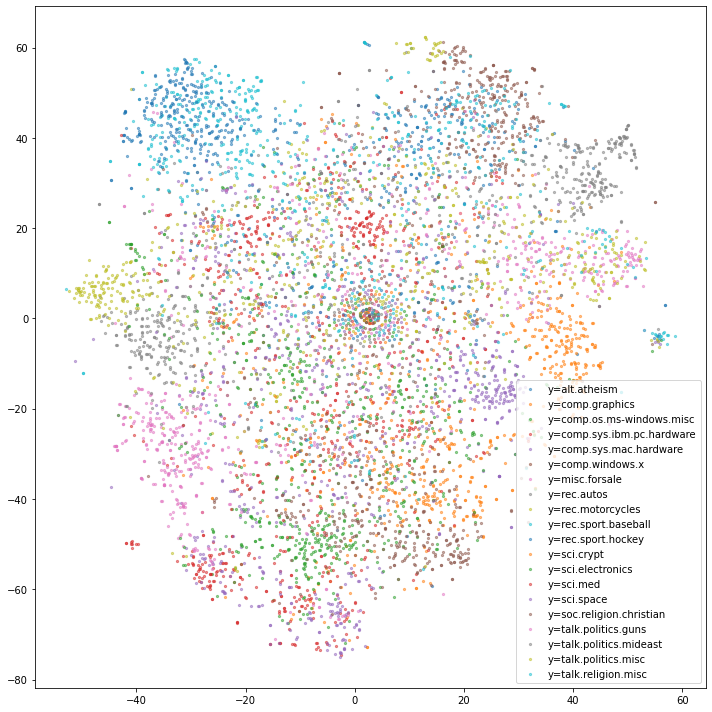

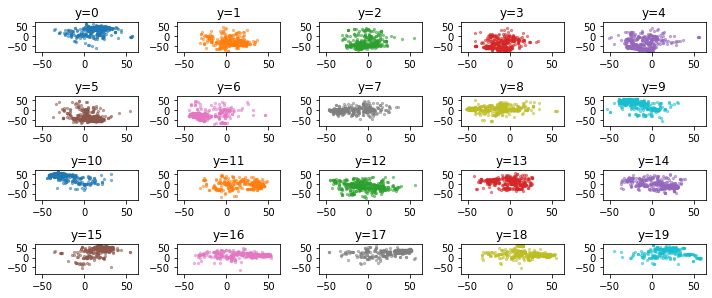

In [13]:
# TODO : automate this - whole evaluation process
# Embedding visualization
# t-sne
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
zs = []
z_mus = []
xs = []
ys = []

for (x, y) in test_loader:
    if len(x) == BATCH_SIZE:
        q = model.encoder(x.cuda().double())
        z_groups = []
        mu_groups = []
        for i in range(NUM_GROUPS):
            z = q['z_'+str(i)].value.cpu().detach().numpy()
            mu = q['z_'+str(i)].dist.mean.cpu().detach().numpy()
            z_groups.append(z)
            mu_groups.append(mu)
        z = np.concatenate(z_groups, axis=-1)
        zs.append(z.reshape(-1, LATENT_DIM))
        z_mu = np.concatenate(mu_groups, axis=-1)
        z_mus.append(z_mu.reshape(-1, LATENT_DIM))
        xs.append(x.numpy())
        ys.append(y.numpy())

zs = np.concatenate(zs, 0)
z_mus = np.concatenate(z_mus, 0)
xs = np.concatenate(xs, 0)
ys = np.concatenate(ys, 0)
zs_mean = zs.mean(0)
zs_std = zs.std(0)

%matplotlib inline
#zs2 = TSNE().fit_transform(zs)
zs2 = TSNE().fit_transform(z_mus)

fig = plt.figure(figsize=(10,10))
ax = plt.gca()

colors = []
for k in range(len(labels)):
    m = (ys==k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%s'%labels[k], s=5, alpha=0.5)
    colors.append(p.get_facecolor())
ax.legend()
fig.tight_layout()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
# save figure
plt.savefig(SAVE_PATH+'tsne.png')


# for each class independently
fig = plt.figure(figsize=(10,4.25))

for k in range(len(labels)):
    ax = plt.subplot(4,5,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()
plt.savefig(SAVE_PATH+'tsne_by_class.png')



#### Correlation plot (z)

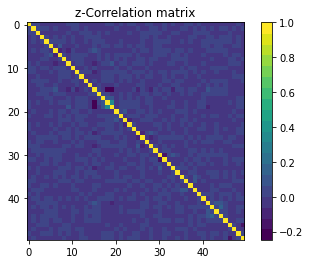

In [13]:
#correlation plot
from matplotlib import cm
cov_matrix = np.corrcoef(zs.T)
plt.imshow(cov_matrix, interpolation='None', cmap=cm.get_cmap('viridis',20))
plt.title('z-Correlation matrix')
plt.colorbar()
# plt.savefig(SAVE_PATH+'z-correlations.png')
# ok - correlations within a group(top left, bottom right)
# no correlations between groups (top right, bottom left)


#### Top words

In [14]:
from evaluation.topics import print_top_words
from utils.file_handling import MultiOutput
# save output
f = open(SAVE_PATH+'topics.txt','w')
original = sys.stdout
sys.stdout = MultiOutput(sys.stdout, f)
# Top words in topics
# load the vocab
vocab = json.load(open(DATA_PATH+'vocab.json','r'))
idx2word = {i:vocab[i] for i in range(len(vocab))}
# get weights of the decoder
emb = model.decoder.main[0].weight.cpu().detach().numpy().T
print_top_words(emb, idx2word)
sys.stdout = original
f.close()



--------------- Topics ------------------
van fonts penalty kings font weapon division section adams flames
objective morality december arabs israeli muslim won jews population auto
catholic gordon greek tradition vga define church principle usenet postings
nasa mission arab shuttle orbit mary solar land launch space
health sin islamic offer holy traditional law page son energy
court surrender legal law banks illegal encryption strong warrant secure
argic armenian serdar turks armenians genocide turkish muslim armenia doctors
devices device manufacturers scsi escrow technology policy protect industry chip
escrow chips nsa unit detroit manufacturer warrant slot encryption pin
offer dos sale model manual light shipping original includes condition
apple insurance canada zone wave power defense edge annual control
system problem back windows water window mouse goal driver oil
oil service document privacy list price copies turks article performance
information knowledge form space work moon

#### NPMI

In [15]:
from evaluation.topics import npmi_coherence_score
import pickle
X_raw = json.load(open(DATA_PATH+'X_raw.json','r'))
decoder_weight = model.decoder.main[0].weight.detach().cpu()
top_words = 10
topics = [
    [idx2word[item.item()] for item in topic]
    for topic in decoder_weight.topk(10, dim=0)[1].t()
]
word_frequencies = pickle.load(open(DATA_PATH+'word_frequencies.pkl','rb'))
joint_word_frequencies = pickle.load(open(DATA_PATH+'jointword_frequencies.pkl','rb'))
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic)/len(npmi_per_topic))
print('Max: %f'%max(npmi_per_topic))
print('Topic : %s'%(' '.join(topics[np.argmax(npmi_per_topic)])))
# save results
json.dump({'npmi_per_topic':npmi_per_topic, 'avg_npmi':sum(npmi_per_topic)/len(npmi_per_topic)},open(SAVE_PATH+'npmi.json','w'))



[0.02458376154823308, 0.09241219058875291, 0.08579145641346299, 0.2140001340086111, 0.15690364868159562, 0.2653333866615283, 0.6861989669670506, 0.2684199682538426, -0.038396222203420434, 0.24975179478140225, 0.19371219003224746, 0.14040119798140435, 0.19143597890518171, 0.22200992675137607, 0.24540386528278246, 0.3414944834274217, 0.0016404841567453834, -0.21098329735923244, 0.2894045752617243, 0.3042933398883678, 0.16933166406977523, 0.12521210088460719, -0.1686324376070073, 0.17524293525271903, 0.22194220025753225, 0.16416289688147434, -0.03915658843042192, 0.094553768816021, 0.11053154654028631, 0.2995862318052542, 0.19017284953323987, 0.023176731310972195, 0.07608100693396723, 0.07640030045032145, -0.04845994831437513, 0.13235293283378818, 0.2107095571695708, -0.18368154421601518, 0.3579808935420059, 0.11430544076245866, 0.18500665660773324, 0.056153679417576534, 0.15708103971191045, -0.05046669750823318, 0.0635144811378304, 0.12516243842204675, -0.008909288713591902, -0.031501230

In [19]:
# get npmi's for most correlated topics - 4
top_correlations = 4
inds = np.dstack(np.unravel_index(np.argsort(cov_matrix.ravel()), (LATENT_DIM, LATENT_DIM)))[0]
inds = inds[-LATENT_DIM-top_correlations:-LATENT_DIM,:]
print('Inds : ')
print(inds)
covs = [cov_matrix[tuple(ind)] for ind in inds]
print('Covs : ')
print(covs)
cor_topics = sorted(set(inds.flatten()))
for topic in cor_topics:
    print('%d %f %s'%(topic, npmi_per_topic[topic], topics[topic]))



Inds : 
[[48 21]
 [21 48]
 [32 14]
 [14 32]]
Covs : 
[0.11801561582890034, 0.11801561582890034, 0.14471877037209335, 0.14471877037209335]
14 0.248174 ['mail', 'email', 'address', 'items', 'list', 'state', 'university', 'mailing', 'sell', 'registration']
21 0.201360 ['position', 'goals', 'orbit', 'years', 'part', 'period', 'question', 'led', 'face', 'nasa']
32 0.287088 ['proposed', 'announced', 'nasa', 'mail', 'interested', 'access', 'information', 'site', 'sites', 'programming']
48 0.278966 ['rights', 'key', 'approach', 'specific', 'private', 'talk', 'agencies', 'encryption', 'goal', 'organizations']


#### LDA for comparison

In [18]:
import gensim
# training classic LDA just for comparison
corpus = gensim.matutils.Dense2Corpus(train_data, documents_columns=False)
lda = gensim.models.LdaMulticore(corpus=corpus,
                                 id2word=idx2word,
                                 num_topics=50,
                                 random_state=100,
                                 passes=10)

In [19]:
coherence_model = gensim.models.CoherenceModel(model=lda,
                                               texts=X_raw,
                                               dictionary=gensim.corpora.dictionary.Dictionary.from_corpus(corpus, idx2word),
                                               coherence='c_npmi')
topic_coherences = coherence_model.get_coherence_per_topic()
print(topic_coherences)
print(sum(topic_coherences)/len(topic_coherences))

[0.05049653446593177, 0.018853839167305892, 0.13889612641516624, 0.022945950029298473, -0.0006003120676231906, 0.1428051110383231, 0.11315420450649968, 0.0603837412866034, -0.07631427244884832, 0.13477647813050067, -0.12113910056456596, 0.03452064847060468, -0.012526820374331515, 0.13433586922156424, 0.08481460233152115, -0.0046095948153488525, 0.14795521458271274, 0.0643200487789307, 0.09741848749268073, -0.028582443389426147, 0.013560249247074262, -0.029854817229828124, 0.17069680278113172, 0.041594051846695755, 0.023262740152461197, -0.015284992085027458, 0.02957366350989352, -0.012382081119426134, -0.0809209396639903, -0.05902062671151506, -0.03754023400933772, 0.054073430455275046, 0.044970844029611955, 0.004594873432606471, 0.11843654659168892, 0.05827839243050851, -0.12443164045021132, 0.018179347383259856, -0.06328050309834121, 0.003220650621897766, 0.018718541240538306, -0.009209533430282583, 0.09513379877887652, 0.16329721392069838, 0.024118672311393214, -0.06975283708929722,

In [21]:
# with my implementation
topics = lda.show_topics(num_topics=50, num_words=10, formatted=False)
topics = [[t[0] for t in topic[1]] for topic in topics]
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic)/len(npmi_per_topic))
for topic in topics:
    print(topic)



[0.16410033369830448, 0.3111506547532112, 0.3114129065896065, 0.2532044613857142, 0.18540062448569977, 0.3571823886854365, 0.3122368409907439, 0.2697089955510378, 0.14553792552260353, 0.416451331905533, 0.19892567161221894, 0.27745537742764353, 0.20559272753652633, 0.340324700723863, 0.4240882933319373, 0.22213953829759964, 0.4676971884705831, 0.13982192371931396, 0.3665607427566965, 0.18697436442110582, 0.32289840459720787, 0.24979912838610635, 0.3740518835592937, 0.21790243274365118, 0.21180207632988513, 0.20816621490125248, 0.18736735069409186, 0.17593497473809364, 0.17990350537115046, 0.18011868130999345, 0.23890330528870785, 0.237629458728827, 0.16311259013485555, 0.16870227815922761, 0.3344769660198739, 0.23457751758471912, 0.15180438273571348, 0.17458782640347076, 0.1379065730339304, 0.28150057621561597, 0.1909182071256871, 0.28186802094285945, 0.26290095125736423, 0.4331352499031874, 0.15669152368152559, 0.14540524721734785, 0.18392229075549102, 0.14442045864007083, 0.121592459

#### Mutual informtaion - I(x,zd)

In [ ]:
# mutual information
from evaluation.NPEET.npeet import entropy_estimators as ee
import warnings
warnings.filterwarnings("ignore")
mi = ee.mi(xs, zs)
micd = ee.micd(zs, xs)
print(mi)
print(micd)
# THIS IS EXTREMELY SLOW - takes almost as much as training the model
# results are weird

In [ ]:
# using sklearn
from sklearn.feature_selection import mutual_info_regression
# each component of z is treated as a continuous target variable (y)
# x are features, which are discrete
mis = []
for i in range(zs.shape[-1]):
    mi = mutual_info_regression(X=xs, y=zs[...,i], discrete_features=True).mean()
    print(mi)
    mis.append(mi)
print(mis)
print(np.mean(mis))
# also very slow - ~5min per dimension
# results - too low values - all ~ 0.005


#### Mutual information - I(yk,zd)